In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import matplotlib.pyplot as plt


# Utiliser le dossier courant comme base (par défaut dans les notebooks)
base_dir = os.getcwd()

# Chemins des sous-dossiers pour train et test
train_image_dir = os.path.join(base_dir, 'train')
test_image_dir = os.path.join(base_dir, 'test')
val_image_dir = os.path.join(base_dir, 'validation')

# Chemin des fichiers CSV
train_csv_file = os.path.join(base_dir, 'annotations/train.csv')
test_csv_file = os.path.join(base_dir, 'annotations/test.csv')
val_csv_file = os.path.join(base_dir, 'annotations/validation.csv')

# Afficher les chemins pour vérifier
print("Chemin des images d'entraînement :", train_image_dir)
print("Chemin des images de test :", test_image_dir)
print("Chemin des images de validation :", val_image_dir)

print("Chemin du fichier train CSV :", train_csv_file)
print("Chemin du fichier test CSV :", test_csv_file)
print("Chemin du fichier validation CSV :", val_csv_file)


Chemin des images d'entraînement : c:\Users\akues\OneDrive\Documents\process\train
Chemin des images de test : c:\Users\akues\OneDrive\Documents\process\test
Chemin des images de validation : c:\Users\akues\OneDrive\Documents\process\validation
Chemin du fichier train CSV : c:\Users\akues\OneDrive\Documents\process\train.csv
Chemin du fichier test CSV : c:\Users\akues\OneDrive\Documents\process\test.csv
Chemin du fichier validation CSV : c:\Users\akues\OneDrive\Documents\process\validation.csv


In [4]:
import os
from PIL import Image
import pandas as pd
import torch

class HerbariumDataset:
    def __init__(self, image_dir, csv_file, transform=None):
        """
        Dataset pour charger des images et leurs labels à partir d'un dossier et d'un fichier CSV.

        Args:
        - image_dir (str): Chemin vers le dossier contenant les images.
        - csv_file (str): Chemin vers le fichier CSV contenant les noms et labels.
        - transform (callable, optional): Transformations à appliquer sur les images.
        """
        self.image_dir = image_dir
        self.transform = transform

        # Charger le CSV et nettoyer les données
        self.data = pd.read_csv(csv_file, sep=';')

        # Supprimer les lignes où 'normalized_name' est NaN ou vide
        self.data = self.data.dropna(subset=['normalized_name'])
        self.data = self.data[self.data['normalized_name'].str.strip() != '']

        # Vérifier que les fichiers mentionnés existent dans le dossier d'images
        self.filter_missing_files()

        if self.data.empty:
            raise ValueError("Le DataFrame ne contient aucune ligne valide après le filtrage.")

    def filter_missing_files(self):
        """
        Filtrer les lignes dont les fichiers image correspondants n'existent pas.
        """
        valid_rows = []
        for _, row in self.data.iterrows():
            image_name = row['normalized_name'] + '.jpg'
            image_path = os.path.join(self.image_dir, image_name)
            if os.path.exists(image_path):
                valid_rows.append(row)

        self.data = pd.DataFrame(valid_rows)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Charger une image et ses labels.

        Args:
        - idx (int): Index de l'élément à récupérer.

        Returns:
        - image (PIL.Image or torch.Tensor): L'image chargée et transformée.
        - label (torch.Tensor): Les labels associés (épines et feuilles externes acuminées).
        """
        row = self.data.iloc[idx]

        # Récupérer le chemin de l'image
        image_name = row['normalized_name'] + '.jpg'
        image_path = os.path.join(self.image_dir, image_name)

        # Charger l'image
        image = Image.open(image_path).convert('RGB')

        # Appliquer les transformations si spécifiées
        if self.transform:
            image = self.transform(image)

        # Charger les labels
        label = torch.tensor([row['Epines'], row['BF'],row['TF']], dtype=torch.float32)

        return image, label


In [5]:
# Création des mappings id2label et label2id
class_names = ["Epines", "BF", "TF"]
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}

### Transformation appliqué (data augmentation, resize, normalisation)

In [6]:
from torchvision import transforms

# Transformations pour l'entraînement (avec data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformations pour la validation (sans data augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformations pour le test (identiques à la validation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


### Structure pour utiliser les modeles :Davit,CoatNet,VitH

In [ ]:
import timm
from torch import nn
import torch.optim as optim
from transformers import ViTForImageClassification
from torch.optim import AdamW
from transformers import AutoModelForImageClassification, AutoProcessor, AutoImageProcessor



# Charger le modèle pré-entraîné 
#model_name = "hf_hub:timm/davit_small.msft_in1k"
model_name = "coatnet_0_rw_224.sw_in1k"
model = timm.create_model(model_name, pretrained=True,num_classes=3)



# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transform = timm.data.create_transform(**data_config, is_training=False)

# Déplacer le modèle sur le GPU si disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# Vérifier si CUDA est disponible
if torch.cuda.is_available():
    print("CUDA est disponible")
    print("Nombre de GPUs disponibles :", torch.cuda.device_count())
    print("Nom du GPU utilisé :", torch.cuda.get_device_name(torch.cuda.current_device()))
    print("Index du GPU actif :", torch.cuda.current_device())
else:
    print("CUDA n'est pas disponible, utilisation du CPU.")

CUDA est disponible
Nombre de GPUs disponibles : 1
Nom du GPU utilisé : NVIDIA GeForce RTX 4060 Laptop GPU
Index du GPU actif : 0


### Strucure pour utiliser le modele SwinV2 ou apple mobile

In [50]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from torch import nn
"""
processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
model = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
model_name = "microsoft/swinv2-tiny-patch4-window8-256"
"""
processor = AutoImageProcessor.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
model = AutoModelForImageClassification.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
model_name = "apple/mobilevitv2-1.0-imagenet1k-256"


# Adapter la tête de classification à 3 classes
model.classifier = nn.Linear(model.classifier.in_features, 3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


MobileViTV2ForImageClassification(
  (mobilevitv2): MobileViTV2Model(
    (conv_stem): MobileViTV2ConvLayer(
      (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (encoder): MobileViTV2Encoder(
      (layer): ModuleList(
        (0): MobileViTV2MobileNetLayer(
          (layer): ModuleList(
            (0): MobileViTV2InvertedResidual(
              (expand_1x1): MobileViTV2ConvLayer(
                (convolution): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activation): SiLU()
              )
              (conv_3x3): MobileViTV2ConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
 

In [8]:
def collate_fn(batch):
    # Filtrer les exemples qui sont None
    batch = [b for b in batch if b is not None]
    return torch.utils.data.default_collate(batch)


#Create datasets
train_dataset = HerbariumDataset(csv_file=train_csv_file, image_dir=train_image_dir, transform=train_transform)
test_dataset = HerbariumDataset(csv_file=test_csv_file, image_dir=test_image_dir, transform=test_transform)
val_dataset = HerbariumDataset(csv_file=val_csv_file, image_dir=val_image_dir, transform=val_transform)


# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,collate_fn=collate_fn)

### Class weight 

In [9]:
# Calculer les poids des classes à partir des données d'entraînement
def calculate_class_weights(train_loader):
    total_samples = 0
    class_counts = None

    for _, labels in train_loader:
        labels = labels.numpy()
        if class_counts is None:
            class_counts = np.sum(labels, axis=0)
        else:
            class_counts += np.sum(labels, axis=0)
        total_samples += labels.shape[0]

    class_weights = total_samples / (len(class_counts) * class_counts)
    return torch.tensor(class_weights, dtype=torch.float32)

# Calcul des poids des classes
class_weights = calculate_class_weights(train_loader).to(device)

### Loop Training for Timm loaded model 

In [10]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Définir la perte et l'optimiseur
#criterion = nn.BCEWithLogitsLoss()  # Pour classification binaire sur plusieurs catégories
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)  # Ajouter les poids des classes
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Initialisation des listes pour stocker les métriques
epochs = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1s = []
val_f1s = []
train_recalls = []
val_recalls = []
train_precisions = []
val_precisions = []

# Boucle d'entraînement
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    all_train_labels = []
    all_train_preds = []

    print(f"Epoch {epoch + 1}/{num_epochs}")
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device).float()  # Labels doivent être de type float pour BCEWithLogitsLoss

        optimizer.zero_grad()
        logits = model(images)  # Utiliser directement les logits car timm retourne un tenseur
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        probabilities = torch.sigmoid(logits).detach().cpu().numpy()
        predictions = probabilities > 0.5
        all_train_labels.append(labels.cpu().numpy())
        all_train_preds.append(probabilities)
        correct_train += (predictions == labels.cpu().numpy()).sum()

    all_train_labels = np.vstack(all_train_labels)
    all_train_preds = np.vstack(all_train_preds)

    train_f1 = f1_score(all_train_labels, all_train_preds > 0.5, average="macro")
    train_recall = recall_score(all_train_labels, all_train_preds > 0.5, average="macro")
    train_precision = precision_score(all_train_labels, all_train_preds > 0.5, average="macro")
    train_accuracy = correct_train / (len(train_dataset) * 3)

    train_f1s.append(train_f1)
    train_recalls.append(train_recall)
    train_precisions.append(train_precision)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    all_val_labels = []
    all_val_preds = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images = images.to(device)
            labels = labels.to(device).float()
            logits = model(images)  # Utiliser directement les logits car timm retourne un tenseur
            loss = criterion(logits, labels)
            val_loss += loss.item()

            probabilities = torch.sigmoid(logits).cpu().numpy()
            predictions = probabilities > 0.5
            all_val_labels.append(labels.cpu().numpy())
            all_val_preds.append(probabilities)
            correct_val += (predictions == labels.cpu().numpy()).sum()

    all_val_labels = np.vstack(all_val_labels)
    all_val_preds = np.vstack(all_val_preds)

    val_f1 = f1_score(all_val_labels, all_val_preds > 0.5, average="macro")
    val_recall = recall_score(all_val_labels, all_val_preds > 0.5, average="macro")
    val_precision = precision_score(all_val_labels, all_val_preds > 0.5, average="macro")
    val_accuracy = correct_val / (len(val_dataset) * 3)

    val_f1s.append(val_f1)
    val_recalls.append(val_recall)
    val_precisions.append(val_precision)

    # Stocker les métriques
    epochs.append(epoch + 1)
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accuracies.append(train_accuracy * 100)
    val_accuracies.append(val_accuracy * 100)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, Train F1: {train_f1:.4f}, Train Recall: {train_recall:.4f}, Train Precision: {train_precision:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy * 100:.2f}%, Val F1: {val_f1:.4f}, Val Recall: {val_recall:.4f}, Val Precision: {val_precision:.4f}")

# Boucle d'évaluation sur le test set
model.eval()
correct = 0
all_test_labels = []
all_test_preds = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing", leave=False):
        images = images.to(device)
        labels = labels.to(device).float()
        logits = model(images)  # Utiliser directement les logits car timm retourne un tenseur
        probabilities = torch.sigmoid(logits).cpu().numpy()
        predictions = probabilities > 0.5  # Convertir logits en probabilités
        all_test_labels.append(labels.cpu().numpy())
        all_test_preds.append(probabilities)
        correct += (predictions == labels.cpu().numpy()).sum()

all_test_labels = np.vstack(all_test_labels)
all_test_preds = np.vstack(all_test_preds)

f1 = f1_score(all_test_labels, all_test_preds > 0.5, average="macro")
recall = recall_score(all_test_labels, all_test_preds > 0.5, average="macro")
precision = precision_score(all_test_labels, all_test_preds > 0.5, average="macro")
accuracy = correct / (len(test_dataset) * 3)  # Nombre total d'échantillons * 3 catégories

print(f"Test Accuracy: {accuracy * 100:.2f}%, Test F1: {f1:.4f}, Test Recall: {recall:.4f}, Test Precision: {precision:.4f}")


Epoch 1/25


Epoch [1/25], Train Loss: 0.1416, Train Accuracy: 91.70%, Train F1: 0.9562, Train Recall: 0.9751, Train Precision: 0.9395, Val Loss: 0.1037, Val Accuracy: 94.62%, Val F1: 0.9720, Val Recall: 1.0000, Val Precision: 0.9462
Epoch 2/25


Epoch [2/25], Train Loss: 0.0876, Train Accuracy: 95.85%, Train F1: 0.9774, Train Recall: 0.9881, Train Precision: 0.9670, Val Loss: 0.0629, Val Accuracy: 97.13%, Val F1: 0.9845, Val Recall: 0.9883, Val Precision: 0.9808
Epoch 3/25


Epoch [3/25], Train Loss: 0.0441, Train Accuracy: 98.58%, Train F1: 0.9921, Train Recall: 0.9934, Train Precision: 0.9908, Val Loss: 0.0448, Val Accuracy: 97.49%, Val F1: 0.9864, Val Recall: 0.9883, Val Precision: 0.9845
Epoch 4/25


Epoch [4/25], Train Loss: 0.0250, Train Accuracy: 99.05%, Train F1: 0.9948, Train Recall: 0.9974, Train Precision: 0.9922, Val Loss: 0.0355, Val Accuracy: 98.57%, Val F1: 0.9922, Val Recall: 0.9922, Val Precision: 0.9922
Epoch 5/25


Epoch [5/25], Train Loss: 0.0352, Train Accuracy: 97.27%, Train F1: 0.9847, Train Recall: 0.9738, Train Precision: 0.9959, Val Loss: 0.0914, Val Accuracy: 96.77%, Val F1: 0.9829, Val Recall: 1.0000, Val Precision: 0.9667
Epoch 6/25


Epoch [6/25], Train Loss: 0.0495, Train Accuracy: 97.51%, Train F1: 0.9862, Train Recall: 0.9856, Train Precision: 0.9869, Val Loss: 0.0672, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 7/25


Epoch [7/25], Train Loss: 0.0166, Train Accuracy: 99.53%, Train F1: 0.9974, Train Recall: 0.9961, Train Precision: 0.9987, Val Loss: 0.0615, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 8/25


Epoch [8/25], Train Loss: 0.0075, Train Accuracy: 99.88%, Train F1: 0.9994, Train Recall: 0.9987, Train Precision: 1.0000, Val Loss: 0.0698, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 9/25


Epoch [9/25], Train Loss: 0.0055, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.0713, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 10/25


Epoch [10/25], Train Loss: 0.0045, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.0801, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 11/25


Epoch [11/25], Train Loss: 0.0040, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.0792, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 12/25


Epoch [12/25], Train Loss: 0.0062, Train Accuracy: 99.88%, Train F1: 0.9993, Train Recall: 1.0000, Train Precision: 0.9987, Val Loss: 0.0752, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 13/25


Epoch [13/25], Train Loss: 0.0033, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.0906, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 14/25


Epoch [14/25], Train Loss: 0.0038, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.0759, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 15/25


Epoch [15/25], Train Loss: 0.0030, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.0925, Val Accuracy: 97.13%, Val F1: 0.9846, Val Recall: 0.9922, Val Precision: 0.9771
Epoch 16/25


Epoch [16/25], Train Loss: 0.0024, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.0925, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 17/25


Epoch [17/25], Train Loss: 0.0021, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.0934, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 18/25


Epoch [18/25], Train Loss: 0.0020, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.0942, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 19/25


Epoch [19/25], Train Loss: 0.0018, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.0959, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 20/25


Epoch [20/25], Train Loss: 0.0017, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.0979, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 21/25


Epoch [21/25], Train Loss: 0.0016, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.0996, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 22/25


Epoch [22/25], Train Loss: 0.0016, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.0981, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 23/25


Epoch [23/25], Train Loss: 0.0014, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.1003, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 24/25


Epoch [24/25], Train Loss: 0.0013, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.1017, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808
Epoch 25/25


Epoch [25/25], Train Loss: 0.0013, Train Accuracy: 100.00%, Train F1: 1.0000, Train Recall: 1.0000, Train Precision: 1.0000, Val Loss: 0.1028, Val Accuracy: 97.49%, Val F1: 0.9865, Val Recall: 0.9922, Val Precision: 0.9808


Test Accuracy: 98.11%, Test F1: 0.9901, Test Recall: 1.0000, Test Precision: 0.9806


### loop de training pour SwinV2 et applemobileITV

In [51]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Définir la perte et l'optimiseur
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)  # Pour classification binaire sur plusieurs catégories
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Initialisation des listes pour stocker les métriques
epochs = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1s = []
val_f1s = []
train_recalls = []
val_recalls = []
train_precisions = []
val_precisions = []

# Boucle d'entraînement
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    all_train_labels = []
    all_train_preds = []

    print(f"Epoch {epoch + 1}/{num_epochs}")
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device).float()  # Labels doivent être de type float pour BCEWithLogitsLoss

        optimizer.zero_grad()
        outputs = model(images)
        logits = outputs.logits  # Extraire les logits pour la perte
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        probabilities = torch.sigmoid(logits).detach().cpu().numpy()
        predictions = probabilities > 0.5
        all_train_labels.append(labels.cpu().numpy())
        all_train_preds.append(probabilities)
        correct_train += (predictions == labels.cpu().numpy()).sum()

    all_train_labels = np.vstack(all_train_labels)
    all_train_preds = np.vstack(all_train_preds)

    train_f1 = f1_score(all_train_labels, all_train_preds > 0.5, average="macro")
    train_recall = recall_score(all_train_labels, all_train_preds > 0.5, average="macro")
    train_precision = precision_score(all_train_labels, all_train_preds > 0.5, average="macro")
    train_accuracy = correct_train / (len(train_dataset) * 3)

    train_f1s.append(train_f1)
    train_recalls.append(train_recall)
    train_precisions.append(train_precision)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    all_val_labels = []
    all_val_preds = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images = images.to(device)
            labels = labels.to(device).float()
            outputs = model(images)
            logits = outputs.logits  # Extraire les logits pour la validation
            loss = criterion(logits, labels)
            val_loss += loss.item()

            probabilities = torch.sigmoid(logits).cpu().numpy()
            predictions = probabilities > 0.5
            all_val_labels.append(labels.cpu().numpy())
            all_val_preds.append(probabilities)
            correct_val += (predictions == labels.cpu().numpy()).sum()

    all_val_labels = np.vstack(all_val_labels)
    all_val_preds = np.vstack(all_val_preds)

    val_f1 = f1_score(all_val_labels, all_val_preds > 0.5, average="macro")
    val_recall = recall_score(all_val_labels, all_val_preds > 0.5, average="macro")
    val_precision = precision_score(all_val_labels, all_val_preds > 0.5, average="macro")
    val_accuracy = correct_val / (len(val_dataset) * 3)

    val_f1s.append(val_f1)
    val_recalls.append(val_recall)
    val_precisions.append(val_precision)

    # Stocker les métriques
    epochs.append(epoch + 1)
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accuracies.append(train_accuracy * 100)
    val_accuracies.append(val_accuracy * 100)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, Train F1: {train_f1:.4f}, Train Recall: {train_recall:.4f}, Train Precision: {train_precision:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy * 100:.2f}%, Val F1: {val_f1:.4f}, Val Recall: {val_recall:.4f}, Val Precision: {val_precision:.4f}")

# Boucle d'évaluation sur le test set
model.eval()
correct = 0
all_test_labels = []
all_test_preds = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing", leave=False):
        images = images.to(device)
        labels = labels.to(device).float()
        outputs = model(images)
        logits = outputs.logits  # Extraire les logits pour le test
        probabilities = torch.sigmoid(logits).cpu().numpy()
        predictions = probabilities > 0.5  # Convertir logits en probabilités
        all_test_labels.append(labels.cpu().numpy())
        all_test_preds.append(probabilities)
        correct += (predictions == labels.cpu().numpy()).sum()

all_test_labels = np.vstack(all_test_labels)
all_test_preds = np.vstack(all_test_preds)

f1 = f1_score(all_test_labels, all_test_preds > 0.5, average="macro")
recall = recall_score(all_test_labels, all_test_preds > 0.5, average="macro")
precision = precision_score(all_test_labels, all_test_preds > 0.5, average="macro")
accuracy = correct / (len(test_dataset) * 3)  # Nombre total d'échantillons * 3 catégories

print(f"Test Accuracy: {accuracy * 100:.2f}%, Test F1: {f1:.4f}, Test Recall: {recall:.4f}, Test Precision: {precision:.4f}")


Epoch 1/25


Epoch [1/25], Train Loss: 0.2709, Train Accuracy: 52.91%, Train F1: 0.6721, Train Recall: 0.5234, Train Precision: 0.9668, Val Loss: 0.2686, Val Accuracy: 54.84%, Val F1: 0.6591, Val Recall: 0.5523, Val Precision: 0.9765
Epoch 2/25


Epoch [2/25], Train Loss: 0.2631, Train Accuracy: 62.75%, Train F1: 0.7532, Train Recall: 0.6135, Train Precision: 0.9905, Val Loss: 0.2600, Val Accuracy: 62.37%, Val F1: 0.7491, Val Recall: 0.6110, Val Precision: 0.9946
Epoch 3/25


Epoch [3/25], Train Loss: 0.2523, Train Accuracy: 71.65%, Train F1: 0.8229, Train Recall: 0.7017, Train Precision: 0.9964, Val Loss: 0.2515, Val Accuracy: 69.18%, Val F1: 0.8054, Val Recall: 0.6815, Val Precision: 0.9948
Epoch 4/25


Epoch [4/25], Train Loss: 0.2386, Train Accuracy: 74.73%, Train F1: 0.8449, Train Recall: 0.7318, Train Precision: 1.0000, Val Loss: 0.2386, Val Accuracy: 74.91%, Val F1: 0.8479, Val Recall: 0.7388, Val Precision: 0.9948
Epoch 5/25


Epoch [5/25], Train Loss: 0.2189, Train Accuracy: 82.56%, Train F1: 0.8975, Train Recall: 0.8164, Train Precision: 0.9968, Val Loss: 0.2231, Val Accuracy: 77.78%, Val F1: 0.8670, Val Recall: 0.7689, Val Precision: 0.9947
Epoch 6/25


Epoch [6/25], Train Loss: 0.2006, Train Accuracy: 87.78%, Train F1: 0.9302, Train Recall: 0.8708, Train Precision: 0.9985, Val Loss: 0.2083, Val Accuracy: 86.02%, Val F1: 0.9206, Val Recall: 0.8562, Val Precision: 0.9954
Epoch 7/25


Epoch [7/25], Train Loss: 0.1816, Train Accuracy: 93.24%, Train F1: 0.9624, Train Recall: 0.9325, Train Precision: 0.9944, Val Loss: 0.1965, Val Accuracy: 89.96%, Val F1: 0.9436, Val Recall: 0.8969, Val Precision: 0.9956
Epoch 8/25


Epoch [8/25], Train Loss: 0.1619, Train Accuracy: 96.20%, Train F1: 0.9789, Train Recall: 0.9651, Train Precision: 0.9932, Val Loss: 0.1626, Val Accuracy: 94.27%, Val F1: 0.9689, Val Recall: 0.9434, Val Precision: 0.9959
Epoch 9/25


Epoch [9/25], Train Loss: 0.1510, Train Accuracy: 96.09%, Train F1: 0.9782, Train Recall: 0.9600, Train Precision: 0.9972, Val Loss: 0.1480, Val Accuracy: 96.06%, Val F1: 0.9789, Val Recall: 0.9626, Val Precision: 0.9960
Epoch 10/25


Epoch [10/25], Train Loss: 0.1281, Train Accuracy: 98.46%, Train F1: 0.9915, Train Recall: 0.9858, Train Precision: 0.9973, Val Loss: 0.1273, Val Accuracy: 96.77%, Val F1: 0.9828, Val Recall: 0.9701, Val Precision: 0.9960
Epoch 11/25


Epoch [11/25], Train Loss: 0.1344, Train Accuracy: 96.56%, Train F1: 0.9806, Train Recall: 0.9648, Train Precision: 0.9972, Val Loss: 0.1149, Val Accuracy: 96.77%, Val F1: 0.9828, Val Recall: 0.9701, Val Precision: 0.9960
Epoch 12/25


Epoch [12/25], Train Loss: 0.1257, Train Accuracy: 97.86%, Train F1: 0.9882, Train Recall: 0.9805, Train Precision: 0.9960, Val Loss: 0.1237, Val Accuracy: 96.42%, Val F1: 0.9807, Val Recall: 0.9659, Val Precision: 0.9960
Epoch 13/25


Epoch [13/25], Train Loss: 0.1158, Train Accuracy: 98.22%, Train F1: 0.9901, Train Recall: 0.9830, Train Precision: 0.9973, Val Loss: 0.1061, Val Accuracy: 98.92%, Val F1: 0.9943, Val Recall: 0.9925, Val Precision: 0.9961
Epoch 14/25


Epoch [14/25], Train Loss: 0.1187, Train Accuracy: 98.46%, Train F1: 0.9914, Train Recall: 0.9869, Train Precision: 0.9960, Val Loss: 0.0991, Val Accuracy: 98.57%, Val F1: 0.9923, Val Recall: 0.9886, Val Precision: 0.9961
Epoch 15/25


Epoch [15/25], Train Loss: 0.0992, Train Accuracy: 98.22%, Train F1: 0.9901, Train Recall: 0.9831, Train Precision: 0.9973, Val Loss: 0.0910, Val Accuracy: 99.28%, Val F1: 0.9961, Val Recall: 1.0000, Val Precision: 0.9923
Epoch 16/25


Epoch [16/25], Train Loss: 0.0861, Train Accuracy: 99.41%, Train F1: 0.9967, Train Recall: 0.9948, Train Precision: 0.9987, Val Loss: 0.0823, Val Accuracy: 99.28%, Val F1: 0.9961, Val Recall: 1.0000, Val Precision: 0.9923
Epoch 17/25


Epoch [17/25], Train Loss: 0.0943, Train Accuracy: 99.05%, Train F1: 0.9947, Train Recall: 0.9934, Train Precision: 0.9960, Val Loss: 0.0783, Val Accuracy: 98.92%, Val F1: 0.9941, Val Recall: 0.9922, Val Precision: 0.9960
Epoch 18/25


Epoch [18/25], Train Loss: 0.0890, Train Accuracy: 98.81%, Train F1: 0.9934, Train Recall: 0.9895, Train Precision: 0.9973, Val Loss: 0.0783, Val Accuracy: 98.57%, Val F1: 0.9921, Val Recall: 0.9883, Val Precision: 0.9960
Epoch 19/25


Epoch [19/25], Train Loss: 0.0777, Train Accuracy: 99.29%, Train F1: 0.9960, Train Recall: 0.9947, Train Precision: 0.9973, Val Loss: 0.0716, Val Accuracy: 99.28%, Val F1: 0.9961, Val Recall: 1.0000, Val Precision: 0.9923
Epoch 20/25


Epoch [20/25], Train Loss: 0.0714, Train Accuracy: 99.41%, Train F1: 0.9967, Train Recall: 0.9948, Train Precision: 0.9987, Val Loss: 0.0679, Val Accuracy: 98.57%, Val F1: 0.9922, Val Recall: 0.9922, Val Precision: 0.9922
Epoch 21/25


Epoch [21/25], Train Loss: 0.0671, Train Accuracy: 99.05%, Train F1: 0.9948, Train Recall: 0.9922, Train Precision: 0.9974, Val Loss: 0.0598, Val Accuracy: 99.28%, Val F1: 0.9961, Val Recall: 1.0000, Val Precision: 0.9923
Epoch 22/25


Epoch [22/25], Train Loss: 0.0723, Train Accuracy: 99.17%, Train F1: 0.9954, Train Recall: 0.9922, Train Precision: 0.9987, Val Loss: 0.0678, Val Accuracy: 98.92%, Val F1: 0.9942, Val Recall: 1.0000, Val Precision: 0.9885
Epoch 23/25


Epoch [23/25], Train Loss: 0.0635, Train Accuracy: 99.64%, Train F1: 0.9980, Train Recall: 0.9974, Train Precision: 0.9987, Val Loss: 0.0552, Val Accuracy: 98.92%, Val F1: 0.9942, Val Recall: 0.9961, Val Precision: 0.9922
Epoch 24/25


Epoch [24/25], Train Loss: 0.0585, Train Accuracy: 99.53%, Train F1: 0.9974, Train Recall: 0.9948, Train Precision: 1.0000, Val Loss: 0.0665, Val Accuracy: 98.57%, Val F1: 0.9923, Val Recall: 1.0000, Val Precision: 0.9848
Epoch 25/25


Epoch [25/25], Train Loss: 0.0596, Train Accuracy: 99.29%, Train F1: 0.9961, Train Recall: 0.9935, Train Precision: 0.9987, Val Loss: 0.0762, Val Accuracy: 97.85%, Val F1: 0.9884, Val Recall: 0.9961, Val Precision: 0.9809


Test Accuracy: 98.74%, Test F1: 0.9934, Test Recall: 1.0000, Test Precision: 0.9869


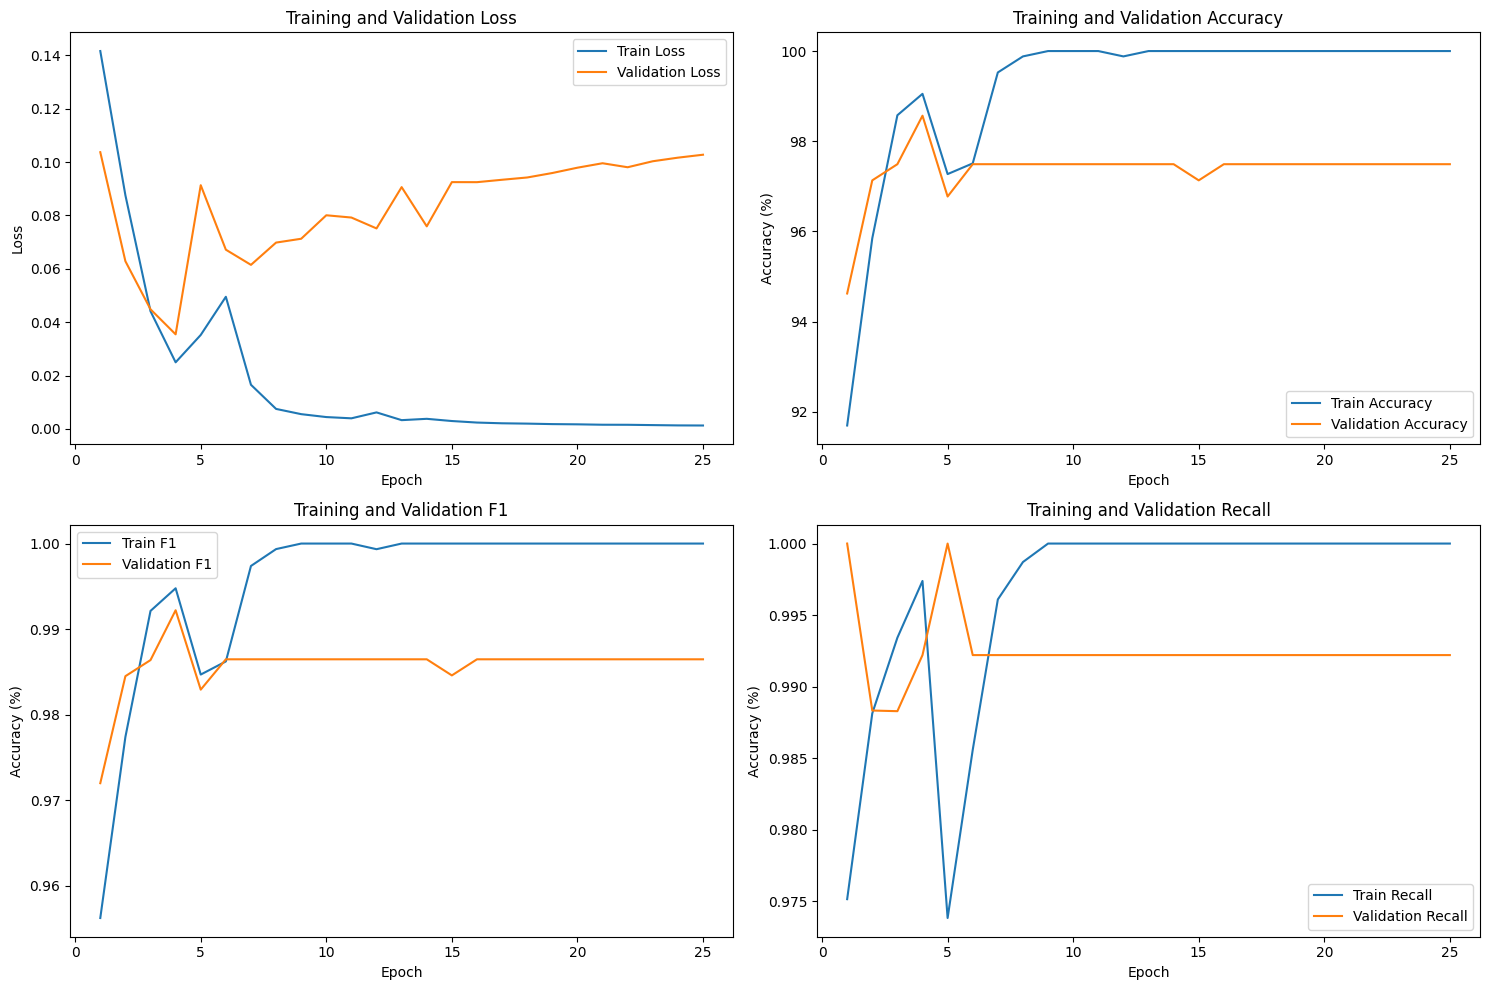

In [11]:


# Créer un dossier pour sauvegarder les résultats
output_dir = model_name.split('/')[-1]
os.makedirs(output_dir, exist_ok=True)

# Tracer les métriques
plt.figure(figsize=(15, 10))

# Tracer les pertes
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Tracer les précisions
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

# Tracer le F1
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1s, label='Train F1')
plt.plot(epochs, val_f1s, label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation F1')

# Tracer le Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label='Train Recall')
plt.plot(epochs, val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Recall')

plt.tight_layout()
# Sauvegarder les graphiques
plot_path = os.path.join(output_dir, "training_metrics.png")
plt.savefig(plot_path)
plt.show()


In [10]:
import json

# Sauvegarder les métriques dans un fichier JSON
metrics = {
    "epochs": epochs,
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies,
    "train_f1s" : train_f1s,
    "val_f1s" : val_f1s,
    "train_recalls" : train_recalls,
    "val_recalls" : val_recalls,
    


}
metrics_path = os.path.join(output_dir, "metrics.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)


### Distribution intra classe

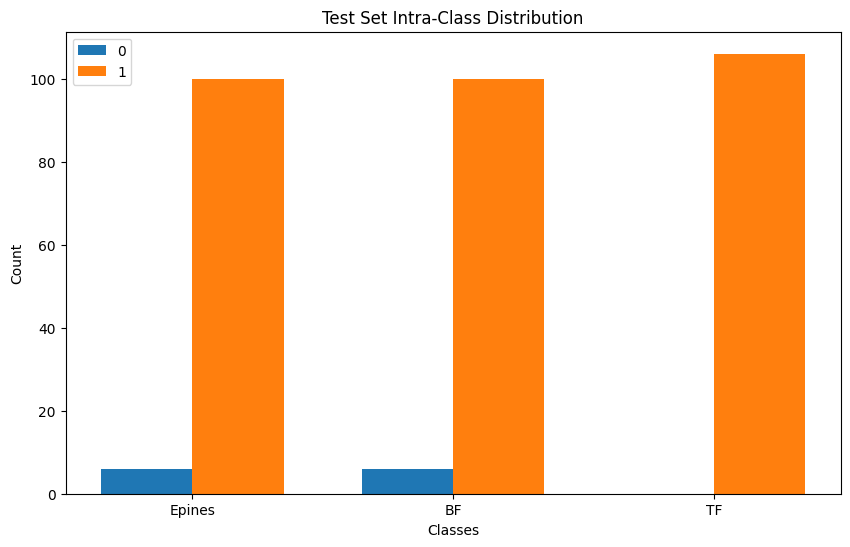

In [37]:
# Fonction pour afficher la distribution intra-classe
def plot_intraclass_distribution(labels, title="Intra-Class Distribution"):
    class_counts_0 = np.sum(labels == 0, axis=0)
    class_counts_1 = np.sum(labels == 1, axis=0)
    class_names = [id2label[i] for i in range(labels.shape[1])]

    x = np.arange(len(class_names))
    width = 0.35  # largeur des barres

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, class_counts_0, width, label="0")
    plt.bar(x + width/2, class_counts_1, width, label="1")

    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.xticks(x, class_names)
    plt.legend()
    plt.show()


# Afficher la distribution intra-classe
data_labels = np.vstack(all_test_labels)  # Remplacez par les labels du dataset à analyser
plot_intraclass_distribution(data_labels, title="Test Set Intra-Class Distribution")


### Inference without timm

In [22]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Fonction d'inférence
def infer_single_image(image, model, transform):
    model.eval()
    with torch.no_grad():
        image = transform(image).unsqueeze(0).to(device)  # Appliquer les transformations et ajouter une dimension batch
        outputs = model(image)
        logits = outputs.logits
        probabilities = torch.sigmoid(logits).cpu().numpy()[0]  # Convertir logits en probabilités
        predictions = probabilities > 0.5  # Seuil pour binariser les prédictions
        return probabilities, predictions

# Exemple d'inférence
from PIL import Image
example_image = Image.open("test\ANG008037.jpg")
probabilities, predictions = infer_single_image(example_image, model, transform)
print("Probabilities:", probabilities)
print("Predictions:", predictions)


Probabilities: [0.9999875  0.99998903 0.9999999 ]
Predictions: [ True  True  True]


### Inference with TIMM

In [36]:
from torchvision import transforms

# Fonction d'inférence
def infer_single_image(image, model, transform):
    model.eval()
    with torch.no_grad():
        image = transform(image).unsqueeze(0).to(device)  # Appliquer les transformations et ajouter une dimension batch
        logits = model(image)  # Utiliser directement les logits car timm retourne un tenseur
        probabilities = torch.sigmoid(logits).cpu().numpy()[0]  # Convertir logits en probabilités
        predictions = probabilities > 0.5  # Seuil pour binariser les prédictions

        # Convertir les prédictions en labels
        predictions_labels = [id2label[idx] for idx, pred in enumerate(predictions) if pred]
        return probabilities, predictions, predictions_labels


# Exemple d'inférence
from PIL import Image
example_image = Image.open("test\ALF043980.jpg")
probabilities, predictions, predictions_labels = infer_single_image(example_image, model, transform)
print("Probabilities:", probabilities)
print("Predictions:", predictions)


Probabilities: [0.48605734 0.42151546 0.55140543]
Predictions: [False False  True]
Predicted Labels: ['TF']
